In [1]:
# loading needed methods
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from random import seed,sample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc,\
precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

In [2]:
data = pd.read_csv("AIML Dataset.csv")


In [3]:
data.describe()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [48]:
data['step'].unique() #steps meands hours

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [49]:
data['isFlaggedFraud'].unique()

array([0, 1], dtype=int64)

In [50]:
#using 8 columns as features
data.shape

(6362620, 11)

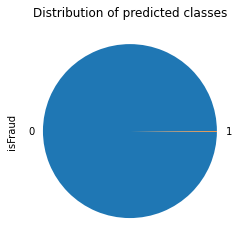

In [51]:
data.isFraud.value_counts().plot(kind='pie', title='Distribution of predicted classes');

In [52]:
data.isFraud.value_counts() 
#No
#Yes

0    6354407
1       8213
Name: isFraud, dtype: int64

In [55]:
def barplot_per_classes(df, attribute, groupby, title=None, ticks_rotation=0, topn=None, ax=None):
    """
    Draw barplot of attribute per each class.
    
    :param df: dataframe with data to be drawn on barplot.
    :param attribute: name of attribute to be drawn on barplot.
    :param groupby: name of attribute with predicted classes.
    :param ticks_rotation: rotation of x-ticks (labels).
    :param topn: number of top categories to be drawn.
    :param ax: matplotlib Axes object to draw the plot onto.
    """
    uniq_values = df[attribute].value_counts().head(topn).index
    df = df[df[attribute].isin(uniq_values)]
    data = df.groupby(groupby)[attribute].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
    sns.barplot(attribute, 'percentage', hue=groupby, data=data, ax=ax)
    plt.xticks(rotation=ticks_rotation)

    
def kdeplot_per_classes(df, attribute, groupby, title=None, ticks_rotation=0, ax=None):
    """
    Draw kdeplot of attribute per each class.
    
    :param df: dataframe with data to be drawn on kdeplot.
    :param attribute: name of attribute to be drawn on kdeplot.
    :param groupby: name of attribute with predicted classes.
    :param title: title of plot.
    :param ticks_rotation: rotation of x-ticks (labels).
    :param ax: matplotlib Axes object to draw the plot onto.
    """
    for x in df[groupby].unique():
        sns.kdeplot(df[df[groupby] == x][attribute], label=x, shade=True, shade_lowest=False, ax=ax)
    plt.title(title)
    plt.xticks(rotation=ticks_rotation)


def boxplot_per_classes(df, attribute, groupby, title=None, ticks_rotation=0, ax=None):
    """
    Draw boxplot of attribute per each class.
    
    :param df: dataframe with data to be drawn on boxplot.
    :param attribute: name of attribute to be drawn on boxplot.
    :param groupby: name of attribute with predicted classes.
    :param title: title of plot.
    :param ticks_rotation: rotation of x-ticks (labels).
    :param ax: matplotlib Axes object to draw the plot onto.
    """
    sns.boxplot(x=groupby, y=attribute, data=df, ax=ax)
    plt.title(title)
    plt.xticks(rotation=ticks_rotation)

In [57]:
import seaborn as sns

In [4]:
data.shape


(6362620, 11)

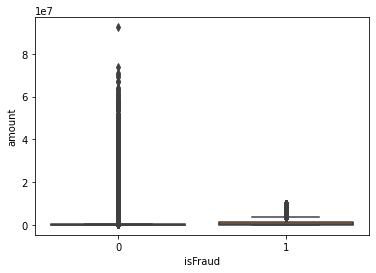

In [60]:
boxplot_per_classes(data, 'amount', 'isFraud') #outliners #none outliners

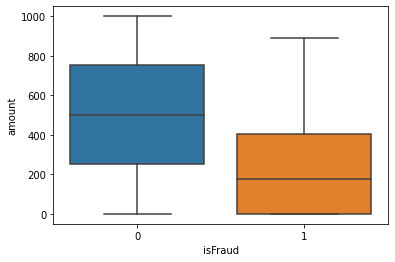

In [61]:
boxplot_per_classes(data[data.amount < 1000], 'amount', 'isFraud')


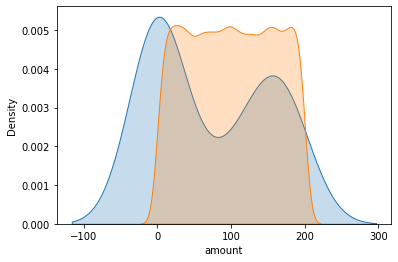

In [62]:
kdeplot_per_classes(data[data.amount < 200], 'amount', 'isFraud')
#shows  us the diffrence between regular and fraudent transactions


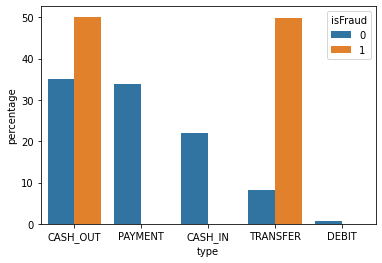

In [63]:
barplot_per_classes(data, 'type', 'isFraud')
#More frauds in Cashout & transfer


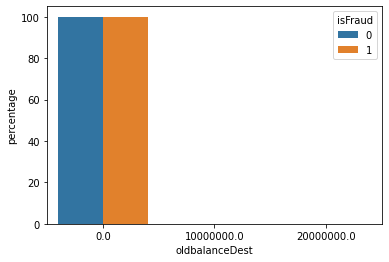

In [64]:
barplot_per_classes(data, 'oldbalanceDest', 'isFraud',topn=3)
#Mostly destination accounts  are 0 balances


In [59]:
# adding feature type1
data_new = data.copy() # creating copy of dataset in case I need original dataset
data_new["type1"] = np.nan # initializing feature column

# filling feature column
data_new.loc[data.nameOrig.str.contains('C') & data.nameDest.str.contains('C'),"type1"] = "CC" 
data_new.loc[data.nameOrig.str.contains('C') & data.nameDest.str.contains('M'),"type1"] = "CM"
data_new.loc[data.nameOrig.str.contains('M') & data.nameDest.str.contains('C'),"type1"] = "MC"
data_new.loc[data.nameOrig.str.contains('M') & data.nameDest.str.contains('M'),"type1"] = "MM"


In [6]:
# Subsetting data into observations with fraud and valid transactions:
fraud = data_new[data_new["isFraud"] == 1]
valid = data_new[data_new["isFraud"] == 0]

In [7]:
# seeing the counts of transactions by type1 (CC,CM,MC,MM)
print("Fraud transactions by type1: \n",fraud.type1.value_counts())
print("\n Valid transactions by type1: \n",valid.type1.value_counts())

Fraud transactions by type1: 
 CC    8213
Name: type1, dtype: int64

 Valid transactions by type1: 
 CC    4202912
CM    2151495
Name: type1, dtype: int64


In [8]:
# getting rid of type1 column.

fraud = fraud.drop('type1', 1)
valid = valid.drop('type1',1)
data_new = data_new.drop('type1',1)

In [9]:
# seeing the counts of transactions by type
print("Fraud transactions by type: \n",fraud.type.value_counts())
print("\n Valid transactions by type: \n",valid.type.value_counts())

Fraud transactions by type: 
 CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

 Valid transactions by type: 
 CASH_OUT    2233384
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     528812
DEBIT         41432
Name: type, dtype: int64


In [10]:
# Subsetting data according to the conclusion above
# I don't have to subset for the fraud dataset because all of their transaction types are either TRANSFER or CASH_OUT

valid = valid[(valid["type"] == "CASH_OUT")| (valid["type"] == "TRANSFER")]
data_new = data_new[(data_new["type"] == "CASH_OUT") | (data_new["type"] == "TRANSFER")]

In [11]:
wrong_orig_bal = sum(data["oldbalanceOrg"] - data["amount"] != data["newbalanceOrig"])
wrong_dest_bal = sum(data["newbalanceDest"] + data["amount"] != data["newbalanceDest"])
print("Percentage of observations with balance errors in the account giving money: ", 100*round(wrong_orig_bal/len(data),2))
print("Percentage of observations with balance errors in the account receiving money: ", 100*round(wrong_dest_bal/len(data),2))

Percentage of observations with balance errors in the account giving money:  85.0
Percentage of observations with balance errors in the account receiving money:  100.0


In [12]:
## Calculating some quantities to justify or reject some assumptions

# flatten the subsetted dataframe of floats into an array of floats
relevant_cols = data[["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]].values.flatten()
# number of observations with negative numbers
num_neg_amt = sum(n < 0 for n in relevant_cols)
# number of observations where the amount given is greater than the amount that is in the giver's account
num_amt_oldgiver = sum(data["amount"] > data["oldbalanceOrg"]) 
# number of observations where the amount received is greater than the amount that is in the receiver's account
num_amt_newreceiver = sum(data["amount"] > data["newbalanceDest"]) 

print("number of observations with negative numbers: ", num_neg_amt)
print("number of observations where the amount given is greater than the amount that is in the giver's account: "
      , num_amt_oldgiver)
print("number of observations where the amount received is greater than the amount that is in the receiver's account: "
      , num_amt_newreceiver)

number of observations with negative numbers:  0
number of observations where the amount given is greater than the amount that is in the giver's account:  4079080
number of observations where the amount received is greater than the amount that is in the receiver's account:  2661141


In [13]:
# counting number of observations where oldbalanceOrg - amount != newbalanceOrig or newbalanceDest + amount != newbalanceDest
# Essentially, I am counting the number of observations where the effects of the transactions are not properly reflected
# the balances of account sending money and the account receiving money.

num_wrong_bal = (data["oldbalanceOrg"] - data["amount"] != data["newbalanceOrig"]) | (data["newbalanceDest"] + data["amount"] != data["newbalanceDest"])
print("Percentage of observations with balance errors: ", 100*round(sum(num_wrong_bal)/len(data),2))

Percentage of observations with balance errors:  100.0


In [14]:
# adding features errorBalanceOrg, errorBalanceDest
data_new["errorBalanceOrg"] = data_new.newbalanceOrig + data_new.amount - data_new.oldbalanceOrg
data_new["errorBalanceDest"] = data_new.oldbalanceDest + data_new.amount - data_new.newbalanceDest

# Subsetting data into observations with fraud and valid transactions:
fraud = data_new[data_new["isFraud"] == 1]
valid = data_new[data_new["isFraud"] == 0]

In [15]:
print("Summary statistics of errorBalanceOrg for fraudulent transactions: \n",fraud["errorBalanceOrg"].describe())
print("\n Summary statistics of errorBalanceOrg for valid transactions: \n",valid["errorBalanceOrg"].describe())

Summary statistics of errorBalanceOrg for fraudulent transactions: 
 count    8.213000e+03
mean     1.069233e+04
std      2.651461e+05
min     -7.450581e-09
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+07
Name: errorBalanceOrg, dtype: float64

 Summary statistics of errorBalanceOrg for valid transactions: 
 count    2.762196e+06
mean     2.868035e+05
std      8.763752e+05
min     -1.000000e-02
25%      5.261343e+04
50%      1.442008e+05
75%      2.804663e+05
max      9.244552e+07
Name: errorBalanceOrg, dtype: float64


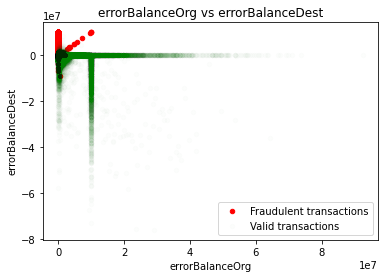

In [16]:
errors = ["errorBalanceOrg", "errorBalanceDest"]
ax = plt.subplot()

fplot = fraud.plot(x="errorBalanceOrg",y="errorBalanceDest",color="red",kind="scatter",ax=ax,label="Fraudulent transactions")
vplot = valid.plot(x="errorBalanceOrg",y="errorBalanceDest",color="green",kind="scatter",\
                   alpha=0.01,ax=ax,label="Valid transactions")
plt.title("errorBalanceOrg vs errorBalanceDest")
plt.show()

In [17]:
print("Proportion of fraudulent transactions with errorBalanceDest > 0: ", len(fraud[fraud.errorBalanceDest > 0])/len(fraud))
print("Proportion of valid transactions with errorBalanceDest > 0: ", len(valid[valid.errorBalanceDest > 0])/len(valid))
print("Proportion of fraudulent transactions with errorBalanceOrg > 0: ", len(fraud[fraud.errorBalanceOrg > 0])/len(fraud))
print("Proportion of valid transactions with errorBalanceOrg > 0: ", len(valid[valid.errorBalanceOrg > 0])/len(valid))

Proportion of fraudulent transactions with errorBalanceDest > 0:  0.5712894192134421
Proportion of valid transactions with errorBalanceDest > 0:  0.19744942067832985
Proportion of fraudulent transactions with errorBalanceOrg > 0:  0.006331425788384269
Proportion of valid transactions with errorBalanceOrg > 0:  0.9067180605576143


In [18]:
print("Fraud transactions by type: \n",fraud.type.value_counts())


Fraud transactions by type: 
 CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64


In [19]:
pd.DataFrame.head(data_new,13)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrg,errorBalanceDest
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0,0.000000e+00,181.00
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0,0.000000e+00,21363.00
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.00,C476402209,5083.0,51513.44,0,0,2.138089e+05,182703.50
19,1,TRANSFER,215310.30,C1670993182,705.00,0.00,C1100439041,22425.0,0.00,0,0,2.146053e+05,237735.30
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.00,C932583850,6267.0,2719172.89,0,0,3.008509e+05,-2401220.00
42,1,CASH_OUT,110414.71,C768216420,26845.41,0.00,C1509514333,288800.0,2415.16,0,0,8.356930e+04,396799.55
47,1,CASH_OUT,56953.90,C1570470538,1942.02,0.00,C824009085,70253.0,64106.18,0,0,5.501188e+04,63100.72
48,1,CASH_OUT,5346.89,C512549200,0.00,0.00,C248609774,652637.0,6453430.91,0,0,5.346890e+03,-5795447.02
51,1,CASH_OUT,23261.30,C2072313080,20411.53,0.00,C2001112025,25742.0,0.00,0,0,2.849770e+03,49003.30
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.20,C1937962514,517.0,8383.29,0,0,0.000000e+00,54744.51


In [20]:
# separating transfers and cashouts for fraud accounts

fraud_transfer = fraud[fraud["type"] == "TRANSFER"]
fraud_cashout = fraud[fraud["type"] == "CASH_OUT"]

# checking if the recipient account of a fraudulent transfer was used as a sending account for cashing out 
fraud_transfer.nameDest.isin(fraud_cashout.nameOrig).any()

False

In [25]:
flagged = data_new[data_new["isFlaggedFraud"] == 1]
flagged_correctly = sum(flagged["isFraud"] == 1)
flagged_wrongly = len(flagged) - flagged_correctly
total = flagged_correctly + flagged_wrongly
print(flagged_correctly," observations were flagged correctly and ", flagged_wrongly, \
      " observations were flagged wrongly for a total of ", total, " flagged observations.")

# how many observations where the transaction is fraudulent, the transaction is a transfer and the amount is greater 
# than 200, 000 are in the dataset
should_be_flagged = fraud[(fraud["amount"] > 200000) & (fraud["type"] == "TRANSFER")]
print("number of observations that should be flagged: ",len(should_be_flagged))

16  observations were flagged correctly and  0  observations were flagged wrongly for a total of  16  flagged observations.
number of observations that should be flagged:  2740


In [26]:
# dropping isFlaggedFraud column from the fraud,valid, and new_data datasets

fraud = fraud.drop("isFlaggedFraud",1)
valid = valid.drop("isFlaggedFraud",1)
data_new = data_new.drop("isFlaggedFraud",1)

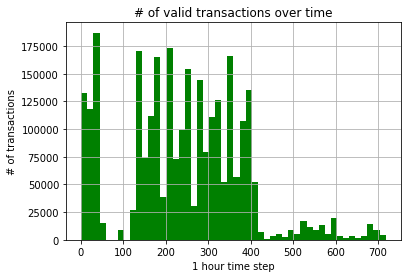

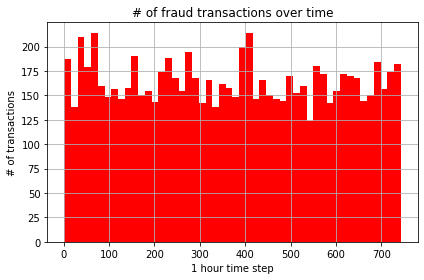

In [27]:
bins = 50

valid.hist(column="step",color="green",bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of valid transactions over time")

fraud.hist(column ="step",color="red",bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of fraud transactions over time")

plt.tight_layout()
plt.show()

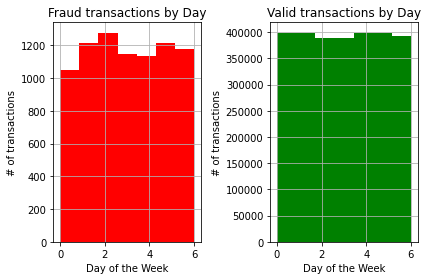

In [28]:
# getting hours and days of the week
num_days = 7
num_hours = 24
fraud_days = fraud.step % num_days
fraud_hours = fraud.step % num_hours
valid_days = valid.step % num_days
valid_hours = valid.step % num_hours

# plotting scatterplot of the days of the week, identifying the fraudulent transactions (red) from the valid transactions (green) 
plt.subplot(1, 2, 1)
fraud_days.hist(bins=num_days,color="red")
plt.title('Fraud transactions by Day')
plt.xlabel('Day of the Week')
plt.ylabel("# of transactions")

plt.subplot(1,2,2)
valid_days.hist(bins=num_days,color="green")
plt.title('Valid transactions by Day')
plt.xlabel('Day of the Week')
plt.ylabel("# of transactions")

plt.tight_layout()
plt.show()

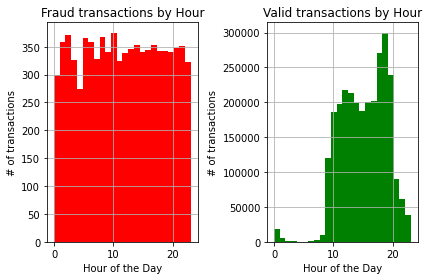

In [29]:
plt.subplot(1, 2, 1)
fraud_hours.hist(bins=num_hours, color="red")
plt.title('Fraud transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")


plt.subplot(1, 2, 2)
valid_hours.hist(bins=num_hours, color="green")
plt.title('Valid transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")

plt.tight_layout()
plt.show()

In [30]:
dataset1 = data_new.copy()


# adding feature HourOfDay to Dataset1 
dataset1["HourOfDay"] = np.nan # initializing feature column
dataset1.HourOfDay = data_new.step % 24


print("Head of dataset1: \n", pd.DataFrame.head(dataset1))

Head of dataset1: 
     step      type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
2      1  TRANSFER     181.00          181.0             0.0             0.0   
3      1  CASH_OUT     181.00          181.0             0.0         21182.0   
15     1  CASH_OUT  229133.94        15325.0             0.0          5083.0   
19     1  TRANSFER  215310.30          705.0             0.0         22425.0   
24     1  TRANSFER  311685.89        10835.0             0.0          6267.0   

    newbalanceDest  isFraud  errorBalanceOrg  errorBalanceDest  HourOfDay  
2             0.00        1             0.00             181.0          1  
3             0.00        1             0.00           21363.0          1  
15        51513.44        0        213808.94          182703.5          1  
19            0.00        0        214605.30          237735.3          1  
24      2719172.89        0        300850.89        -2401220.0          1  


In [31]:
print("Summary statistics on the amounts moved in fraudulent transactions: \n",pd.DataFrame.describe(fraud.amount),"\n")
print("Summary statistics on the amounts moved in valid transactions: \n", pd.DataFrame.describe(valid.amount),"\n")

Summary statistics on the amounts moved in fraudulent transactions: 
 count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64 

Summary statistics on the amounts moved in valid transactions: 
 count    2.762196e+06
mean     3.141155e+05
std      8.771441e+05
min      1.000000e-02
25%      8.290823e+04
50%      1.710345e+05
75%      3.059942e+05
max      9.244552e+07
Name: amount, dtype: float64 



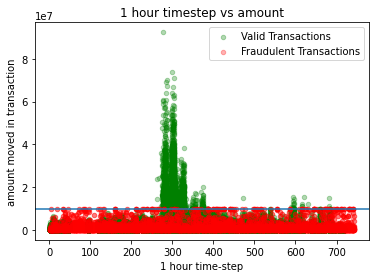

Proportion of transactions where the amount moved is greater than 10 million:  0.0008818192548464865


In [32]:
# plotting overlayed step vs amount scatter plots

alpha = 0.3
fig,ax = plt.subplots()
valid.plot.scatter(x="step",y="amount",color="green",alpha=alpha,ax=ax,label="Valid Transactions")
fraud.plot.scatter(x="step",y="amount",color="red",alpha=alpha,ax=ax, label="Fraudulent Transactions")

plt.title("1 hour timestep vs amount")
plt.xlabel("1 hour time-step")
plt.ylabel("amount moved in transaction")
plt.legend(loc="upper right")

# plotting a horizontal line to show where valid transactions behave very differently from fraud transactions

plt.axhline(y=10000000)
plt.show()


print("Proportion of transactions where the amount moved is greater than 10 million: ", \
      len(data_new[data_new.amount > 10000000])/len(data_new))

In [33]:
dataset = dataset1.copy() # unchanged dataset1

In [34]:
# getting one-hot encoding of the 'type' variable

dataset = pd.get_dummies(dataset,prefix=['type'])

In [35]:
# Setting random_state and seed so that the training/testing splits and model results are reproducible
RandomState = 42
seed(21)


# 42 is used often due to Hitchhiker's Guide to the Galaxy, I will use a number that a far smaller group may understand.
# Not that the actual number doesn't matter and is only used to make sure results are reproducible.
# creating training and testing sets
X = dataset.drop("isFraud",1)
y = dataset.isFraud
X_train, X_test, y_train, y_test = train_test_split(X, y)
    
# Normalizing data so that all variables follow the same scale (0 to 1)
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
ncols = len(X.columns)
hidden_layers = (ncols,ncols,ncols)
max_iter = 1000
MLP = MLPClassifier(hidden_layer_sizes=hidden_layers,max_iter=1000,random_state=RandomState)

# training model
MLP.fit(X_train,y_train)
    
# evaluating model on how it performs on balanced datasets
predictionsMLP = MLP.predict(X_test)
CM_MLP = confusion_matrix(y_test,predictionsMLP)
CR_MLP = classification_report(y_test,predictionsMLP)
fprMLP, recallMLP, thresholdsMLP = roc_curve(y_test, predictionsMLP)
AUC_MLP = auc(fprMLP, recallMLP)
    
resultsMLP = {"Confusion Matrix":CM_MLP,"Classification Report":CR_MLP,"Area Under Curve":AUC_MLP}

In [38]:
# showing results from Multilayered perceptrons developed from each dataset
for measure in resultsMLP:
    print(measure,": \n",resultsMLP[measure])

Confusion Matrix : 
 [[690431    140]
 [   279   1753]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690571
           1       0.93      0.86      0.89      2032

    accuracy                           1.00    692603
   macro avg       0.96      0.93      0.95    692603
weighted avg       1.00      1.00      1.00    692603

Area Under Curve : 
 0.9312470598050225


In [39]:
# Train model
parametersRF = {'n_estimators':15,'oob_score':True,'class_weight': "balanced",'n_jobs':-1,\
                 'random_state':RandomState}
RF = RandomForestClassifier(**parametersRF)
fitted_vals = RF.fit(X_train, y_train)
 
# Predict on testing set
predictionsRF = RF.predict(X_test)
 
     
# Evaluating model
CM_RF = confusion_matrix(y_test,predictionsRF)
CR_RF = classification_report(y_test,predictionsRF)
fprRF, recallRF, thresholdsRF = roc_curve(y_test, predictionsRF)
AUC_RF = auc(fprRF, recallRF)

resultsRF = {"Confusion Matrix":CM_RF,"Classification Report":CR_RF,"Area Under Curve":AUC_RF}

In [40]:
# showing results from Random Forest

for measure in resultsRF:
    print(measure,": \n",resultsRF[measure])

Confusion Matrix : 
 [[690570      1]
 [    11   2021]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690571
           1       1.00      0.99      1.00      2032

    accuracy                           1.00    692603
   macro avg       1.00      1.00      1.00    692603
weighted avg       1.00      1.00      1.00    692603

Area Under Curve : 
 0.9972925830481011


In [37]:
#XGBOOST

In [41]:
# Train model
weights = (y == 0).sum() / (1.0 * (y == 1).sum()) # for unbalanced datasets, these weights are recommended
parametersXGB = {'max_depth':3,'scale_pos_weight': weights,'n_jobs':-1,\
                 'random_state':RandomState,'learning_rate':0.1}
XGB = XGBClassifier(**parametersXGB)
    
fitted_vals = XGB.fit(X_train, y_train)
 
# Predict on testing set
predictionsXGB = XGB.predict(X_test)
 
     
# Evaluating model
CM_XGB = confusion_matrix(y_test,predictionsXGB)
CR_XGB = classification_report(y_test,predictionsXGB)
fprXGB, recallXGB, thresholds_XGB = roc_curve(y_test, predictionsXGB)
AUC_XGB = auc(fprXGB, recallXGB)
resultsXGB = {"Confusion Matrix":CM_XGB,"Classification Report":CR_XGB,"Area Under Curve":AUC_XGB}

[20:31:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [42]:
# showing results from Extreme Gradient Boosting
for measure in resultsXGB:
    print(measure,": \n",resultsXGB[measure],"\n")

Confusion Matrix : 
 [[690385    186]
 [     9   2023]] 

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690571
           1       0.92      1.00      0.95      2032

    accuracy                           1.00    692603
   macro avg       0.96      1.00      0.98    692603
weighted avg       1.00      1.00      1.00    692603
 

Area Under Curve : 
 0.9976507619074376 



In [43]:
print("Number of valid transactions labelled as fraudulent by Random Forest: \n", CM_RF[0,1])
print("Number of valid transactions labelled as fraudulent by XGB trees: \n", CM_XGB[0,1])

Number of valid transactions labelled as fraudulent by Random Forest: 
 1
Number of valid transactions labelled as fraudulent by XGB trees: 
 186


In [44]:
print("Number of fraud transactions labelled as valid by Random Forest: \n", CM_RF[1,0])
print("Number of fraud transactions labelled as valid by XGB trees: \n", CM_XGB[1,0])

Number of fraud transactions labelled as valid by Random Forest: 
 11
Number of fraud transactions labelled as valid by XGB trees: 
 9


In [45]:
print("Note: scores in the same vertical level as 0 are scores for valid transactions. \n \
      Scores in the same vertical level as 1 are scores for fraudulent transactions. \n")
print("Classification Report of Random Forest: \n", CR_RF)
print("Classification Report of XGB trees: \n", CR_XGB)

Note: scores in the same vertical level as 0 are scores for valid transactions. 
       Scores in the same vertical level as 1 are scores for fraudulent transactions. 

Classification Report of Random Forest: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690571
           1       1.00      0.99      1.00      2032

    accuracy                           1.00    692603
   macro avg       1.00      1.00      1.00    692603
weighted avg       1.00      1.00      1.00    692603

Classification Report of XGB trees: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    690571
           1       0.92      1.00      0.95      2032

    accuracy                           1.00    692603
   macro avg       0.96      1.00      0.98    692603
weighted avg       1.00      1.00      1.00    692603




Receiver Operating Characteristic Curves for Random Forests and Extreme Gradient Boosted Trees: 



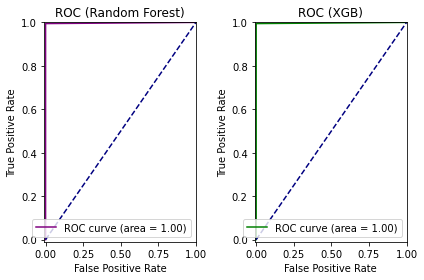


AUC of Random Forest: 
 0.9972925830481011

AUC of XGB trees: 
 0.9976507619074376


In [46]:
print("\nReceiver Operating Characteristic Curves for Random Forests and Extreme Gradient Boosted Trees: \n")
plt.subplot(1, 2, 1)
plt.plot(fprRF, recallRF, color='purple', label='ROC curve (area = %0.2f)' % AUC_RF)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Random Forest)')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(fprRF, recallRF, color='green', label='ROC curve (area = %0.2f)' % AUC_RF)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (XGB)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

print("\nAUC of Random Forest: \n", AUC_RF)
print("\nAUC of XGB trees: \n", AUC_XGB)

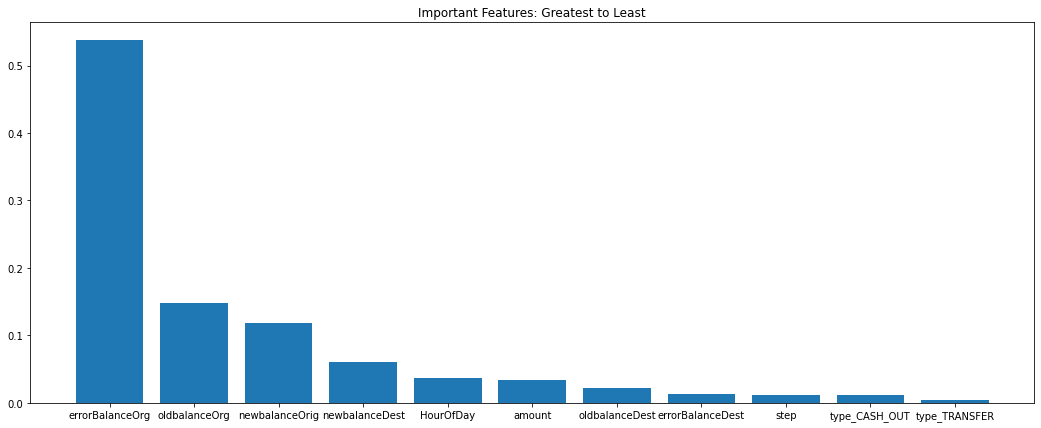

In [47]:
x = np.arange(ncols)

# getting importances of features
importances = RF.feature_importances_

# getting the indices of the most important feature to least important
sort_ind = np.argsort(importances)[::-1]
plt.figure(figsize=(18,7))
plt.bar(x, importances[sort_ind])
plt.xticks(x,tuple(X.columns.values[sort_ind]))
plt.title("Important Features: Greatest to Least")
plt.show()

In [ ]:
df = df.loc[df['Asset'] != 'cut']